### RFC

### import modules and configure notebook

In [1]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot
import pickle

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN

%matplotlib inline

### Load variables stored by data_preproccessing notebook

In [2]:
%store -r train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques
%store -r best_feats


### configurations
* save_plots -> True|False
* random_seed_state -> number, sets random state for model and for stratified splits 
* classify_bedrock_only -> True|False
* pickle_model -> True|False, wether model should be serialised and saved
* pickle_model_name -> string, name of serialised model
* grid_search -> True|False, if set to true then grid search is performed to identify optimum hyperparamaters for model 
* scale -> True|False if set to True then features scaled to all have mean value 0 and standard deviation 1
* pickle_file_path -> string,  filepath for serialised model to be saved to

In [3]:
save_plots = False
random_seed_state = 42
classify_bedrock_only = False
pickle_model = False
pickle_model_name = 'grouped'
pickle_file_path = '../../../model'
grid_search = False
scale = True

### if only bedrock sites are classified then classes are label encoded, if bedrock sites alone are not being classified then the class sites would have already been label encoded in the 1 data_preproccessing notebook 

In [4]:
if classify_bedrock_only:
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])
    train_data_formodel = train_data_formodel[train_data_formodel['Geology']=='Bedrock']

### counts of instances in all classes before oversampling

In [5]:
train_data_formodel['class'].value_counts()

22    120
4     105
23    105
16    100
21     74
17     61
24     60
0      53
12     45
14     36
2      36
15     36
6      30
11     30
10     30
7      30
20     28
5      27
8      27
19     27
1      24
13     21
3      18
18     18
9      17
Name: class, dtype: int64

### The class column is stored as the variable y 

In [6]:
y = np.array(train_data_formodel['class'])

### The variables identified as best by the 2 feature_selection notebook are used as features

In [7]:
train_data_feats = train_data_formodel[best_feats]

### address class imbalance using synthetic minority oversampling technique (SMOTE) algorithm

In [8]:
if scale:
    my_scaler = StandardScaler()
    X = np.array(my_scaler.fit_transform(np.array(train_data_feats)))
else:
    X = np.array(np.array(train_data_feats))

### the dimensions of the class and features are checked

In [9]:
print(X.shape)
print(y.shape)

(1158, 31)
(1158,)


In [10]:
%%time
if grid_search:
    
    esti = MLPClassifier(solver = 'lbfgs')
    random_grid = {
    'hidden_layer_sizes': [(30,30,30),(50,50,50), (50,100,50), (100, 50, 50), (50,100,100), (50,50,50,50), (50,50,50,50,50)],
    'activation': ['tanh', 'relu'],
    'alpha': 10.0 ** -np.arange(1, 10),
    'learning_rate': ['constant','adaptive'],
    }
    
    clf = RandomizedSearchCV(estimator = esti, n_iter=200, param_distributions = random_grid,
                              n_jobs=-1, scoring='f1_macro', cv = 3, verbose=3, 
                              random_state = random_seed_state)
    
    clf.fit(X, y)
    print(clf.best_params_)
    mistake

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


best paramaters from randomised gridsearch were {'learning_rate': 'constant', 'hidden_layer_sizes': (50, 100, 100), 'alpha': 0.1, 'activation': 'tanh'}


### Gri dsearch is done to identify best hyperparamaters for the model

In [11]:
%%time
if grid_search:
    esti = MLPClassifier(solver = 'lbfgs', activation = 'tanh', learning_rate = 'constant')
    parameter_grid = {
    'hidden_layer_sizes': [(50,100,100), (50,200,200), (80, 100, 100), (30,100,100), (50,100,200), (10, 50, 100, 300)],
    'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    }
    clf = GridSearchCV(esti, param_grid=parameter_grid, n_jobs=-1, error_score='f1_macro', cv = 3, verbose=3)
    clf.fit(X, y)
    print(clf.best_params_)
    MISTAKE

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [12]:
%%time
if grid_search:
    esti = MLPClassifier(solver = 'lbfgs', activation = 'tanh', learning_rate = 'constant', alpha = 0.1)
    parameter_grid = {
    'hidden_layer_sizes': [(50,300,300), (50,200,200), (50, 400, 400), (20,200,200), (50,100,300), (50, 300, 300, 300)],
    }
    clf = GridSearchCV(esti, param_grid=parameter_grid, n_jobs=-1, error_score='f1_macro', cv = 3, verbose=3)
    clf.fit(X, y)
    print(clf.best_params_)
    MISTAKE

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs


best params from grid search were {'alpha': 0.1, 'hidden_layer_sizes': (50, 200, 200)}

### Carry out 10-f0ld stratified cross validation, class f1 scores and macro f1 scores with weighted averages are calculated

In [13]:
%%time
esti = MLPClassifier(hidden_layer_sizes=(50, 200, 200), activation = 'tanh', max_iter=20000, alpha=0.1,
                    solver='lbfgs', verbose=3,  random_state=random_seed_state,tol=0.0000000000001, learning_rate  ='constant')
skf = StratifiedKFold(n_splits=10, random_state=random_seed_state)
skf.get_n_splits(X, y)
class_f1_scores = []
macro_f1_scores = []
accuracy_scores = []
feat_imp =[]
f1_dict = {}
feat_imp_dict = {}
count = 0
for train_index, test_index in skf.split(X, y):
    count = count + 1
    print('making model:')
    key = 'round' + str(count)
    print(count)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_post_smote, y_post_smote = SMOTE(random_state=42).fit_sample(X_train, y_train)
        
    esti.fit(X_post_smote, y_post_smote)
    y_pred = esti.predict(X_test)
    class_f1_scores = f1_score(y_test, y_pred, average = None)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    macro_f1_scores.append(f1_score(y_test, y_pred, average = 'weighted'))
    f1_dict[key] = class_f1_scores 
    #feat_imp_dict[key] = esti.feature_importances_

making model:
1
making model:
2
making model:
3
making model:
4
making model:
5
making model:
6
making model:
7
making model:
8


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
9


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


making model:
10
CPU times: user 1h 28min 35s, sys: 3min 31s, total: 1h 32min 6s
Wall time: 23min 8s


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
f1_df = pd.DataFrame(data = f1_dict)


In [15]:
for key in f1_dict:
    print(len(f1_dict[key]))

25
25
25
25
25
25
25
25
25
25


### Below are the encodings for the class variable

In [16]:
print(train_data_formodel['class'].unique())
print(list(uniques))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
['FH', 'ER', 'WW', 'TC', 'CS', 'KQ', 'AR', 'SL', 'FG', 'WB', 'BX', 'PF', 'WH', 'SQ', 'WN', 'BH', 'PH', 'LB', 'AB', 'LV', 'SE', 'BA', 'SV', 'WA', 'MM']


In [17]:
f1_df_final = pd.concat([f1_df, pd.Series(uniques)], axis = 1)

In [18]:
f1_df_final.rename(columns={0:'class'}, inplace=True)
f1_df_final.set_index('class', drop = True, inplace = True)

### Boxplot showing the distribution of class f1 scores from 10 models

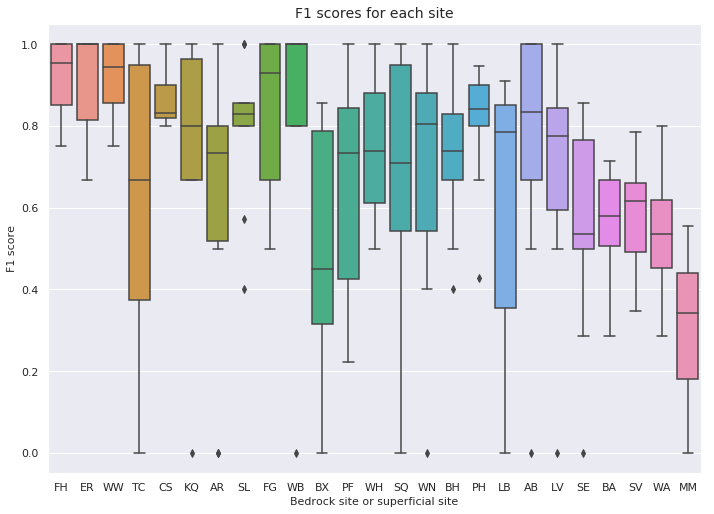

In [19]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(data = f1_df_final.T)
plot.set_title('F1 scores for each site', fontdict={'fontsize': 14})
plot.set_ylabel('F1 score', fontdict={'fontsize': 11})
plot.set_xlabel("Bedrock site or superficial site", fontdict={'fontsize': 11})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('output/site_specific_f1_scores.png')

In [20]:
#pd.DataFrame(data = f1_df_final.T.median()).to_csv('output/median_class_f1_scores.csv')

### Boxplot showing the macro F1 score with weighted averages

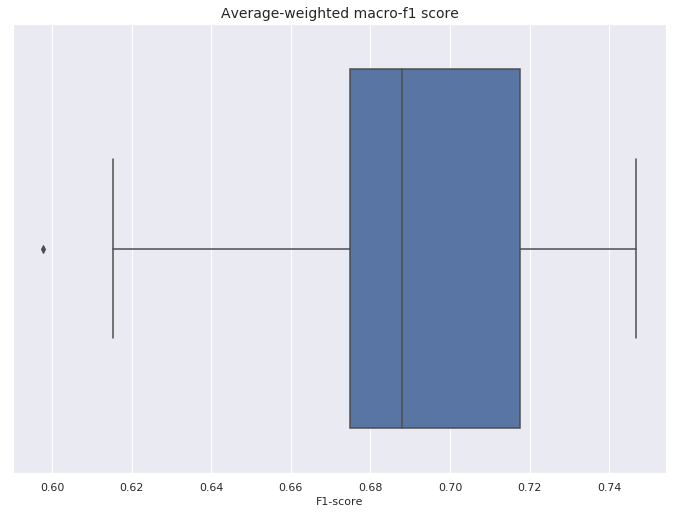

In [21]:
plot = sns.boxplot(macro_f1_scores)
plot.set_title('Average-weighted macro-f1 score', fontdict={'fontsize': 14})
plot.set_xlabel("F1-score", fontdict={'fontsize': 11})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('output/macro_f1_scores.png')

In [22]:
#pd.Series(pd.Series(macro_f1_scores).median()).to_csv('output/median_macro_f1.csv')

In [23]:
pd.Series(macro_f1_scores).median()

0.6880264260714815

### Boxplot showing accuracy scores

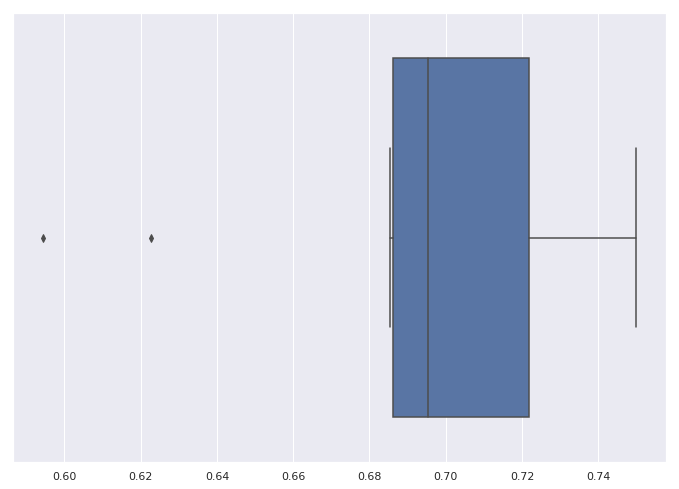

In [24]:
sns.boxplot(accuracy_scores)

### Get feature importances

feat_imp_df = pd.DataFrame(data = feat_imp_dict)
feat_imp_df.head()

feat_imp_df_final = pd.concat([feat_imp_df, pd.Series(my_data[my_data.columns.values[9:-1]].columns.values)], axis = 1)
feat_imp_df_final.rename(columns = {0:'element'}, inplace = True )
feat_imp_df_final.head()

feat_imp_df_final.set_index('element', inplace=True)


feat_imp_df_final_plot = feat_imp_df_final.T

feat_imp_df_final_plot

elements = feat_imp_df_final_plot.columns.values 
mean_feature_importance = []
for col in list(feat_imp_df_final_plot.columns.values):
    mean_feature_importance.append(feat_imp_df_final_plot[col].mean())
    

mean_feature_importance_df = pd.concat([pd.Series(elements), pd.Series(mean_feature_importance)], axis = 1)

mean_feature_importance_df.rename(columns={0:'elements', 1:'mean_importance'}, inplace=True)

mean_feature_importance_df.sort_values(by='mean_importance', ascending=False, inplace=True)

ordered_col_names = list(mean_feature_importance_df['elements'])

sns.set_style("whitegrid")
sns.set_style()
sns.set(rc={'figure.figsize':(20,20)})
plot = sns.boxplot(data = feat_imp_df_final_plot[ordered_col_names])
plot.set_xticklabels(plot.get_xticklabels(),rotation=90, ha = 'left')
plot.set_title('Feature (element) importance', fontdict={'fontsize': 20})
plot.set_ylabel('Feature importance', fontdict={'fontsize': 15})
plot.set_xlabel("Element", fontdict={'fontsize': 15})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('output/feature_importances.png')

### Model is built for predicting source of artefacts 

esti_final = MLPClassifier(hidden_layer_sizes=(100, 50, 50), activation = 'tanh', max_iter=3000, alpha=0.1,
                    solver='lbfgs', verbose=3,  random_state=42,tol=0.0000000001, learning_rate  ='constant')

esti_final.fit(X, y)

In [25]:
if pickle_model == True:
    pickle.dump(esti_final, open(pickle_file_path+'.sav', 'wb'))

print(train_data_formodel['class'].unique())
print(uniques)

df_for_identifiers = test_data.copy(deep = True)
identifiers =  df_for_identifiers['Analysis']

### Predictions are made for the artefacts

y_pred = esti_final.predict(np.array(test_data[test_data.columns.values[9:-1]]))

y_pred_proba = esti_final.predict_proba(np.array(test_data[test_data.columns.values[9:-1]]))


probabilities_df = pd.DataFrame(data = y_pred_proba, columns = uniques)
probabilities_df_final = pd.concat([probabilities_df, pd.Series(list(identifiers))], axis = 1)

probabilities_df_final.rename(columns = {0:'identifier'}, inplace=True)

final_pred_df = pd.concat([pd.Series(y_pred), probabilities_df_final], axis = 1)

final_pred_df.rename(columns={0:'class_number'}, inplace = True)

### predictions are outputted as csv file

final_pred_df.to_csv('output/predictions.csv')


uniques_list = list(uniques)
def get_pred_names(row):
    return(uniques_list[row['class_number']])
final_pred_df['class_predictions'] = final_pred_df.apply(get_pred_names, axis = 1)

final_pred_df.head()